In [1]:
import matplotlib.pyplot as plt

plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
import jax

from datetime import date

rng_key = jax.random.key(int(date.today().strftime("%Y%m%d")))
from functools import partial
from warnings import filterwarnings

from flax import linen as nn
from flax.linen.initializers import ones
import jax.numpy as jnp
import numpy as np
import tensorflow_probability.substrates.jax.distributions as tfd

from sklearn.datasets import make_moons
from sklearn.preprocessing import scale

import blackjax

filterwarnings("ignore")
import matplotlib as mpl

cmap = mpl.colormaps["coolwarm"]

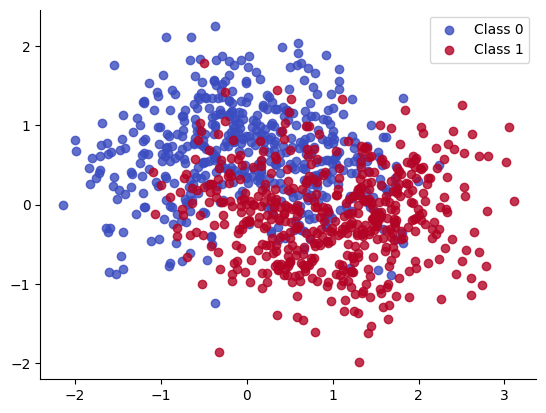

In [2]:
n_samples = 1000
grid = jnp.mgrid[-3:3:100j, -3:3:100j].reshape((2, -1)).T

Xs, Ys = make_moons(noise=0.5, n_samples=n_samples)
for i in range(2):
    plt.scatter(Xs[Ys == i, 0], Xs[Ys == i, 1], color=cmap(float(i)), label=f"Class {i}", alpha=.8)
plt.legend();

In [3]:
Xs_train = Xs[: n_samples // 2 ,:]
Xs_test = Xs[n_samples // 2 :,:]
Ys_train = Ys[: n_samples // 2]
Ys_test = Ys[n_samples // 2 :]

In [4]:
def inference_loop(rng_key, step_fn, initial_state, num_samples):
    def one_step(state, rng_key):
        state, _ = step_fn(rng_key, state)
        return state, state

    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)

    return states

In [5]:
def get_predictions(model, samples, X, rng_key):
    vectorized_apply = jax.vmap(model.apply, in_axes=(0, None), out_axes=0)
    z = vectorized_apply(samples, X)
    predictions = tfd.Bernoulli(logits=z).sample(seed=rng_key)

    return predictions.squeeze(-1)

In [6]:
def get_mean_predictions(predictions, threshold=0.5):
    # compute mean prediction and confidence interval around median
    mean_prediction = jnp.mean(predictions, axis=0)
    return mean_prediction > threshold

In [7]:
def fit_and_eval(
    rng_key,
    model,
    logdensity_fn,
    X_train,
    Y_train,
    X_test,
    grid,
    n_groups=None,
    num_warmup=1000,
    num_samples=500,
):
    (
        init_key,
        warmup_key,
        inference_key,
        train_key,
        test_key,
        grid_key,
    ) = jax.random.split(rng_key, 6)

    if n_groups is None:
        initial_position = model.init(init_key, jnp.ones(X_train.shape[-1]))
    else:
        initial_position = model.init(init_key, jnp.ones(X_train.shape))

    # initialization
    logprob = partial(logdensity_fn, X=X_train, Y=Y_train, model=model)

    # warm up
    adapt = blackjax.window_adaptation(blackjax.nuts, logprob)
    (final_state, params), _ = adapt.run(warmup_key, initial_position, num_warmup)
    step_fn = blackjax.nuts(logprob, **params).step

    # inference
    states = inference_loop(inference_key, step_fn, final_state, num_samples)
    samples = states.position

    # evaluation
    predictions = get_predictions(model, samples, X_train, train_key)
    Y_pred_train = get_mean_predictions(predictions)

    predictions = get_predictions(model, samples, X_test, test_key)
    Y_pred_test = get_mean_predictions(predictions)

    pred_grid = get_predictions(model, samples, grid, grid_key)

    return Y_pred_train, Y_pred_test, pred_grid

# MLP

In [8]:
# MLP params
hidden_layer_width = 5
n_hidden_layers = 2

class NN(nn.Module):
    n_hidden_layers: int
    layer_width: int

    @nn.compact
    def __call__(self, x):
        for i in range(self.n_hidden_layers):
            x = nn.Dense(features=self.layer_width)(x)
            x = nn.tanh(x)
        return nn.Dense(features=1)(x)


bnn = NN(n_hidden_layers, hidden_layer_width)

In [9]:
def logprior_fn(params):
    leaves, _ = jax.tree_util.tree_flatten(params)
    flat_params = jnp.concatenate([jnp.ravel(a) for a in leaves])
    return jnp.sum(tfd.Normal(0, 1).log_prob(flat_params))


def loglikelihood_fn(params, X, Y, model):
    logits = jnp.ravel(model.apply(params, X))
    return jnp.sum(tfd.Bernoulli(logits).log_prob(Y))


def logdensity_fn_of_bnn(params, X, Y, model):
    return logprior_fn(params) + loglikelihood_fn(params, X, Y, model)

In [10]:
rng_key, eval_key = jax.random.split(rng_key)


def fit_and_eval_single_mlp(key, X_train, Y_train, X_test):
    return fit_and_eval(
        key, bnn, logdensity_fn_of_bnn, X_train, Y_train, X_test, grid, n_groups=None
    )


Ys_pred_train, Ys_pred_test, ppc_grid_single = fit_and_eval_single_mlp(eval_key, Xs_train, Ys_train, Xs_test)

{'params': {'Dense_0': {'bias': Array([[ 0.09363369, -0.28051105,  1.2002461 , -0.76451707, -0.01520901],
       [ 2.0041194 ,  0.4157481 , -0.17319259, -0.5280077 ,  0.44913194],
       [ 0.8365158 , -1.5477371 , -0.56516117, -0.8448244 , -0.12476853],
       ...,
       [ 0.40193218,  0.39831874, -1.1044309 ,  0.48144627, -0.65759426],
       [ 0.05663281,  0.31091517,  0.09127738,  0.8567018 , -1.2841514 ],
       [ 0.8560419 ,  0.37326086, -2.3262608 ,  1.3752985 , -1.0659575 ]],      dtype=float32), 'kernel': Array([[[-0.5640266 ,  1.609882  , -0.8881257 , -1.7698839 ,
         -0.6225603 ],
        [-0.06003979,  1.3685653 ,  0.60895   , -0.50454456,
         -0.644805  ]],

       [[-1.0053847 , -1.0570848 , -0.38154975, -2.0345926 ,
         -1.3937845 ],
        [ 0.20071118, -0.64603835,  0.33309212, -0.19688146,
         -1.0532994 ]],

       [[-0.22460775,  1.351537  ,  2.2037349 , -2.0907834 ,
          0.33568102],
        [-0.14999978, -0.62776965,  1.4911102 ,  1.03082

In [11]:
print(f"Train accuracy = {100 * jnp.mean(Ys_pred_train == Ys_train):.2f}%")

Train accuracy = 82.40%


In [12]:
print(f"Test accuracy = {100 * jnp.mean(Ys_pred_test == Ys_test):.2f}%")

Test accuracy = 81.80%


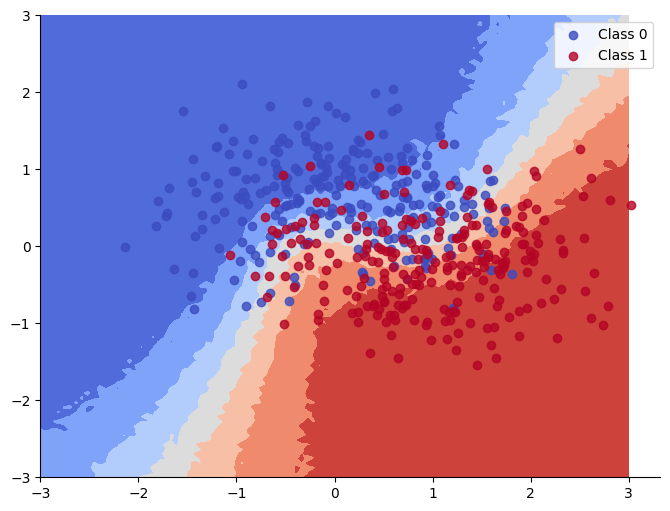

In [13]:
def plot_decision_surfaces_non_hierarchical():
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.contourf(
        grid[:, 0].reshape(100, 100),
        grid[:, 1].reshape(100, 100),
        ppc_grid_single[...].mean(axis=0).reshape(100, 100),
        cmap=cmap,
    )
    for i in range(2):
        ax.scatter(
            Xs_train[Ys_train == i, 0], Xs_train[Ys_train == i, 1], 
            color=cmap(float(i)), label=f"Class {i}", alpha=.8)
    ax.legend()

plot_decision_surfaces_non_hierarchical()